In [1]:
import pandas as pd
import numpy as np
import os
import math
import random

os.makedirs('lscour_calcs', exist_ok=True)

# From Trampush et al., 2014
Trampush_velocities = {
    '50':1.2843137254901962,
    '25':0.8413867822318526,
    '75':1.6939077776156426
}

a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)

trampush_2014 = pd.read_csv('3rd_party/trampush_2014_utf8.csv')
trampush_WD = np.nanmean(trampush_2014['Wbf [m]']/trampush_2014['Hbf [m]']) # Average width to depth ratio

seconds_in_month = 2629800

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

rho = 1000 # density of water (kg/m^3)
ps =  2650 # density of sediment (kg/m^3)
t_crit = 0.03 # critical shields stress

def estimate_tc(row):
    # Lamb et al., 2008
    return np.power(0.15*row['S [-]'], 0.25)
    
Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)

def Hbf_K_and_J(row): 
    return Hbf_Dunne(row['S [-]'], row['t_c_bank'], rho, g)

def Hbf_velocity(row):
    if row['discharge [cms]'] > 5:
        return row['discharge [cms]']/row['U [m/s]']/row['Width [m]']
    else:
        return row['Width [m]']/trampush_WD

def tb_depth_slope(row):
    return rho*g*row['Hbf [m]']*row['S [-]']
    
def estimate_Cf(row):
    return (g*row['S [-]']*row['Hbf [m]'])/np.power(row['U [m/s]'], 2)

def L_b(row):
    return row['Hbf [m]']/row['S [-]']/1000

# Ma et al., 2017 D50

def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + np.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + np.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

def Qs_Ma(row):
    
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]'])        
    
    tau_star = ((row['Hbf [m]'])*row['S [-]'])/(R*row['D50 [m]'])
    
    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m]'],3))
    
    return qs*row['Width [m]']

def t_adj_Ma(row):
    
    m2_per_s = float(row['Qs Ma [cms]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['L_b [km]'])*1000 # m
    hbf = float(row['Hbf [m]'])*row['flood_multiple'] # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    # Return months
    return t_adj_s/seconds_in_month

def cms_WBMSed(row):
    return float(row['WBMSed Qs [kgs]']/ps)

def t_adj_WBMSed(row):
    
    m2_per_s = float(row['WBMSed Qs [kgs]']/ps)/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['L_b [km]'])*1000 # m
    hbf = float(row['Hbf [m]'])*row['flood_multiple'] # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    # Return months
    return t_adj_s/seconds_in_month



In [2]:
# Monte Carlo Simulations

global_avulsions = pd.read_csv(os.path.join('data', 'global_avulsion_db_merged_saved.csv'))
global_avulsions = global_avulsions.loc[global_avulsions['Width [m]'] > 0]
global_avulsions = global_avulsions.loc[global_avulsions['WBMSed Qs [kgs]'] > 0]
global_avulsions = global_avulsions.loc[global_avulsions['D50 [m] (recorded)'] > 0]

print(global_avulsions)
num_reps = 5000

df_all = pd.DataFrame()

for rid, row in global_avulsions.iterrows():

    # Uniform distribution of slope within IQR
    
    print(row['Av_ID'])
    
    S = []
    
    if row['S_IQR [-]'] > 0:
        
        lower_bound = row['S [-]']-(row['S_IQR [-]']*0.5)
        upper_bound = row['S [-]']+(row['S_IQR [-]']*0.5)
        
        while len(S)<num_reps:
            slope = random.uniform(lower_bound, upper_bound)
            if slope > 0:
                S.append(slope)
    else:
        
        S = [row['S [-]']]*num_reps
    
    # Uniform distribution of widths using standard deviation
        
    if row['Width_std [m]'] > 0:
        widths = np.random.normal(row['Width [m]'], row['Width_std [m]'], num_reps)
    else:
        widths = [row['Width [m]']]*num_reps

    df = pd.DataFrame({'S [-]': S, 'Width [m]': widths})
    
    df['Av_ID'] = row['Av_ID']
    df['River'] = row['River']
    df['L_A [km]'] = row['L_A [km]']
    df['L_A_error [km]'] = row['L_A_error [km]']
    df['WBMSed Qs [kgs]'] = row['WBMSed Qs [kgs]']
    
#     df['t_c'] = df.apply(estimate_tc, axis=1)
    df['t_c'] = t_crit
  
    t_c_bank = []
    
    for _ in range(num_reps): t_c_bank.append(random.randrange(6, 11, 1))
    
    df['t_c_bank'] = t_c_bank    
    
    flood_multiple = []
    for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
    # e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

    df['flood_multiple'] = flood_multiple
    
    # Flow velocity
    
    U = []
    for _ in range(num_reps): U.append(random.uniform(Trampush_velocities['25'], Trampush_velocities['75']))
    df['U [m/s]'] = U
    
    df['discharge [cms]'] = row['discharge [cms]']

    # Channel depths (Either Velocity or K&J)
        
    if row['Hbf [m] (recorded)'] > 0:  
        df['Hbf [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf [m]'] = df.apply(Hbf_velocity, axis=1)
    
    if (row['From'] != 'madagascar'):
        df['Hbf (recorded) [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf (recorded) [m]'] = 0
    
    df['Hbf (velocity) [m]'] = df.apply(Hbf_velocity, axis=1)
    df['Hbf (K&J) [m]'] = df.apply(Hbf_K_and_J, axis=1)
    
    
    df['L_b [km]'] = df.apply(L_b, axis=1)
    
    df['t_b'] = df.apply(tb_depth_slope, axis=1)
    
    if row['D50 [m] (recorded)'] > 0:
        df['D50 [m]'] = row['D50 [m] (recorded)']
    else:
        df['D50 [m]'] = df.apply(get_D50, axis=1)
    
    if row['Cf'] > 0:
        df['Cf'] = row['Cf']
    else:
        df['Cf'] = df.apply(estimate_Cf, axis=1)
    
    # Sediment flux
    
    df['Qs Ma [cms]'] = df.apply(Qs_Ma, axis=1)
    df['Tadj_Ma_2017'] = df.apply(t_adj_Ma, axis=1)
    df['Qs WMBSed [cms]'] = df.apply(cms_WBMSed, axis=1)
    df['Tadj_WBMSed'] = df.apply(t_adj_WBMSed, axis=1)
    
    df_all = df_all.append(df)

              Av_ID                            River    Year        From  \
0      AFR0211_1998                        Catumbela  1998.0       study   
1        ANGO2_2003                         Coporolo  2003.0       study   
2       BS0115_1995                             Kura  1995.0       study   
6       JAVA12_1985                    Bengawan Solo  1985.0       study   
20      PI0019_1989                     Batu Gerigis  1989.0       study   
21      PI0209_2006                           Pemali  2006.0       study   
62             NILE                             Nile     NaN      global   
63        MAGDALENA                        Magdalena     NaN      global   
64          ORINOCO                          Orinoco     NaN      global   
65            RHINE                      Rhine-Meuse     NaN      global   
66           DANUBE                           Danube     NaN      global   
67           PARANA                           Paraná     NaN      global   
68      MISS

In [3]:
def IQR(dat):
    return np.nanpercentile(dat, 75)-np.nanpercentile(dat, 25)

df_grouped = df_all.groupby("Av_ID").agg([np.nanmedian, IQR, np.mean, np.std])

# avocado_prices.plot(kind = "scatter", y = "mean", legend = False, title = "Test", xerr = "std")

df_grouped

S [-]                                  Width [m]  \
                nanmedian       IQR      mean       std    nanmedian   
Av_ID                                                                  
AFR0211_1998     0.000348  0.000099  0.000348  0.000058   160.138542   
ANGO2_2003       0.003077  0.000087  0.003078  0.000050   226.071421   
BS0115_1995      0.000303  0.000301  0.000299  0.000172    88.537407   
DANUBE           0.000050  0.000000  0.000050  0.000000   870.000000   
FIHERENANA_2001  0.002232  0.000195  0.002232  0.000113    38.050000   
HUANGHE_1930     0.000064  0.000000  0.000064  0.000000   400.000000   
JAVA12_1985      0.000176  0.000113  0.000177  0.000064   114.008968   
MAGDALENA        0.000095  0.000000  0.000095  0.000000   850.000000   
MANAMBOLO_2004   0.000599  0.000103  0.000599  0.000059   505.590000   
MANGOKY          0.000769  0.000035  0.000769  0.000020   949.800000   
MISS_LAFOURCHE   0.000043  0.000000  0.000043  0.000000   880.000000   
MISS_MODERN      0.000043  0.000000  0.000043  0.000000   880.000000   
MORONDAVA_1979   0.001389  0.000062  0.001390  0.000036   188.920000   
NILE             0.000064  0.000000  0.000064  0.000000   500.000000   
ORINOCO          0.000060  0.000000  0.000060  0.000000  1400.000000   
PARANA           0.000040  0.000000  0.000040  0.000000  1350.000000   
PI0019_1989      0.000812  0.000215  0.000811  0.000122    83.290282   
PI0209_2006      0.000639  0.000198  0.000639  0.000112    60.184227   
RHINE            0.000110  0.000000  0.000110  0.000000   150.000000   
SAMBAO_2004      0.000565  0.000042  0.000565  0.000024   159.820000   

                                                    L_A [km]       ...  \
                       IQR         mean        std nanmedian  IQR  ...   
Av_ID                                                              ...   
AFR0211_1998     38.735790   160.075476  29.150772     2.049  0.0  ...   
ANGO2_2003       72.713410   226.563562  54.613208    16.376  0.0  ...   
BS0115_1995      18.719817    88.711522  13.837053     7.780  0.0  ...   
DANUBE            0.000000   870.000000   0.000000    95.000  0.0  ...   
FIHERENANA_2001   0.000000    38.050000   0.000000     5.240  0.0  ...   
HUANGHE_1930      0.000000   400.000000   0.000000    51.600  0.0  ...   
JAVA12_1985      14.603515   113.820068  11.096402    27.986  0.0  ...   
MAGDALENA         0.000000   850.000000   0.000000    67.000  0.0  ...   
MANAMBOLO_2004    0.000000   505.590000   0.000000    22.650  0.0  ...   
MANGOKY           0.000000   949.800000   0.000000    55.750  0.0  ...   
MISS_LAFOURCHE    0.000000   880.000000   0.000000   100.000  0.0  ...   
MISS_MODERN       0.000000   880.000000   0.000000   490.000  0.0  ...   
MORONDAVA_1979    0.000000   188.920000   0.000000    38.210  0.0  ...   
NILE              0.000000   500.000000   0.000000   210.000  0.0  ...   
ORINOCO           0.000000  1400.000000   0.000000    78.000  0.0  ...   
PARANA            0.000000  1350.000000   0.000000   210.000  0.0  ...   
PI0019_1989      26.933707    83.285013  20.416205     2.468  0.0  ...   
PI0209_2006      29.293077    60.228370  21.638674     4.700  0.0  ...   
RHINE             0.000000   150.000000   0.000000    51.000  0.0  ...   
SAMBAO_2004       0.000000   159.820000   0.000000    30.450  0.0  ...   

                 Tadj_Ma_2017               Qs WMBSed [cms]                  \
                         mean           std       nanmedian  IQR       mean   
Av_ID                                                                         
AFR0211_1998     2.167625e+02  1.684354e+02        0.026783  0.0   0.026783   
ANGO2_2003       2.642308e-01  1.358800e-01        0.017609  0.0   0.017609   
BS0115_1995      1.936103e+08  7.132806e+09        0.381153  0.0   0.381153   
DANUBE           9.328662e+03  2.528595e+03        1.620679  0.0   1.620679   
FIHERENANA_2001  1.368893e-02  4.164721e-03        0.005635  0.0   0.005635   
HUANGHE_1930     6.471078e+0

[(0.35294117647058826, 1.0, 0.32941176470588235, 1.0), (0.35294117647058826, 1.0, 0.32941176470588235, 1.0), (0.35294117647058826, 1.0, 0.32941176470588235, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (1.0, 0.1803921568627451, 0.1803921568627451, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (0.35294117647058826, 1.0, 0.32941176470588235, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (1.0, 0.1803921568627451, 0.1803921568627451, 1.0), (1.0, 0.1803921568627451, 0.1803921568627451, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (1.0, 0.1803921568627451, 0.1803921568627451, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (0.30980392156862746, 0.3215686274509804, 1.0, 1.0), (0.35294117647058826, 1.0, 0.32941176470588235, 1.0), (0.35294117647058826, 1.0, 0.32941176470588235, 1.0), (0.30980392156862746, 0.3215686274509804, 1

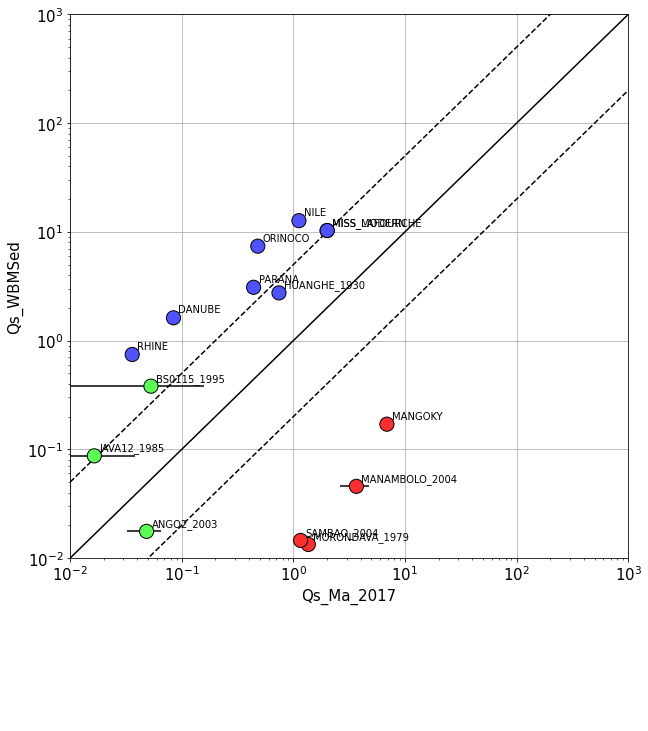

In [61]:
from PIL import ImageColor

# Depth estimation vs. recorded

def hex_2_rgb(hex):
    rgb = ImageColor.getcolor(hex, "RGBA")
    rgb_f = lambda f: float(f)/255
    rgb_v = tuple(map(rgb_f, rgb))
    return rgb_v

study_colours = {'madagascar':'#ff2e2e', 'study':'#5aff54', 'global':'#4f52ff'}
study_color_list = []

for av_id in list(df_grouped.index):
    study_color_list.append(study_colours[global_avulsions.loc[global_avulsions.Av_ID==av_id].From.values[0]])

study_color_list_rgb = list(map(hex_2_rgb, study_color_list))

print(study_color_list_rgb)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000000,1000000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['Qs Ma [cms]']['nanmedian'], 
            df_grouped['Qs WMBSed [cms]']['nanmedian'], 
            xerr=df_grouped['Qs Ma [cms]']['IQR'], 
            yerr=df_grouped['Qs WMBSed [cms]']['IQR'], ms=0,
            mec=(0,0,0,0), mfc=(0,0,0,0), fmt='o', ecolor='k', zorder=20)

ax.scatter(df_grouped['Qs Ma [cms]']['nanmedian'], 
            df_grouped['Qs WMBSed [cms]']['nanmedian'],
            c=study_color_list_rgb, s=200, zorder=90, edgecolors='k')

plt.grid('on')
ax.set_xlabel('Qs_Ma_2017')
ax.set_ylabel('Qs_WBMSed')
ax.set_ylim(bottom=0.01, top=1000)
ax.set_xlim(left=0.01, right=1000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['Qs Ma [cms]']['nanmedian'],row['Qs WMBSed [cms]']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)

    
plt.show()

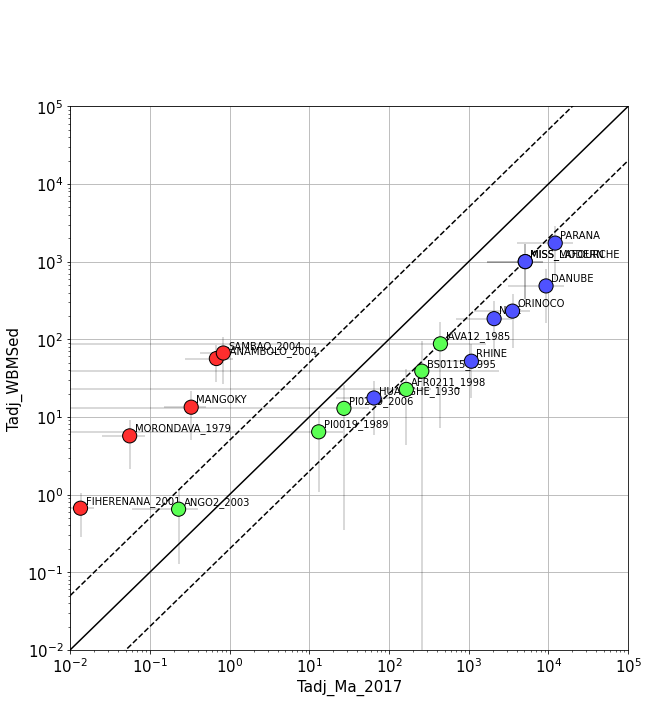

In [71]:
# Depth estimation vs. recorded

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.01,1000000,1000000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['Tadj_Ma_2017']['nanmedian'], 
            df_grouped['Tadj_WBMSed']['nanmedian'], 
            xerr=df_grouped['Tadj_Ma_2017']['IQR'], 
            yerr=df_grouped['Tadj_WBMSed']['IQR'], ms=0,
            mec=(0,0,0,0), mfc=(0,0,0,0), fmt='o', ecolor='k', zorder=20, elinewidth=0.3)

h = ax.scatter(df_grouped['Tadj_Ma_2017']['nanmedian'], 
            df_grouped['Tadj_WBMSed']['nanmedian'],
            c=study_color_list_rgb, s=200, zorder=90, edgecolors='k')

plt.grid('on')
ax.set_xlabel('Tadj_Ma_2017')
ax.set_ylabel('Tadj_WBMSed')
ax.set_ylim(bottom=0.01, top=100000)
ax.set_xlim(left=0.01, right=100000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['Tadj_Ma_2017']['nanmedian'],row['Tadj_WBMSed']['nanmedian']), 
                xytext=(5, 5), xycoords='data', textcoords='offset points', fontsize=10)

plt.savefig('Tadj.jpg')
plt.show()